# Two-Level System with Bloch-Redfield Baths: A Step-by-Step Exploration

This notebook provides an educational introduction to simulating a driven two-level system (qubit) interacting with quantum baths using the Bloch-Redfield master equation. We'll build everything from the ground up, starting with the basic system, then exploring the bath environments, and finally examining how different bath parameters affect the dynamics.

We'll use QuTiP's Bloch-Redfield solver to go beyond phenomenological Lindblad decay and derive the dynamics from explicit spectral densities.

## Building the Two-Level System

A two-level system (TLS) is the simplest quantum system, often called a qubit. It has two energy levels: the ground state |0⟩ and the excited state |1⟩.

The Hamiltonian for a driven TLS is:
$$ H = \frac{\omega_0}{2} \sigma_z + \frac{\Omega}{2} \sigma_x $$

where:
- $\omega_0$ is the bare frequency of the TLS
- $\Omega$ is the driving field amplitude
- $\sigma_z$ and $\sigma_x$ are Pauli matrices

Let's define this in code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import basis, sigmaz, sigmax

# Define the two-level system
# Ground state |0⟩
ground = basis(2, 0)
# Excited state |1⟩
excited = basis(2, 1)

# Pauli matrices
sz = sigmaz()  # σ_z
sx = sigmax()  # σ_x

# System parameters
w0 = 1.0        # Bare frequency (in units where ħ=1)
omega_drive = 1.0  # Driving amplitude

# Hamiltonian: H = (w0/2) σ_z + (Ω/2) σ_x
H_tls = 0.5 * w0 * sz + 0.5 * omega_drive * sx

print("Two-level system Hamiltonian:")
print(H_tls)
print(f"\nEigenvalues: {H_tls.eigenenergies()}")

Two-level system Hamiltonian:
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.5  0.5]
 [ 0.5 -0.5]]

Eigenvalues: [-0.70710678  0.70710678]


## Quantum Baths and Spectral Densities

In the Bloch-Redfield formalism, the environment is characterized by its spectral density $J(\omega)$, which describes how strongly the system couples to bath modes at different frequencies.

We'll consider two common types of baths:

1. **Drude-Lorentz bath**: $J(\omega) = \frac{2\lambda \gamma \omega}{\omega^2 + \gamma^2}$
   - Parameters: reorganization energy $\lambda$, cutoff frequency $\gamma$

2. **Ohmic bath**: $J(\omega) = \alpha \omega^s e^{-\omega/\omega_c}$ (for $\omega > 0$)
   - Parameters: dissipation strength $\alpha$, cutoff frequency $\omega_c$, exponent $s$

The temperature $T$ also plays a crucial role in determining the bath's influence.

Let's define these baths and plot their spectral densities.

/home/leopold/miniconda3/envs/redfield/lib/python3.13/site-packages/qutip/core/environment.py:1647: UserWarning: The mpmath module is required for some operations on Ohmic environments, but it is not installed.
  warnings.warn(


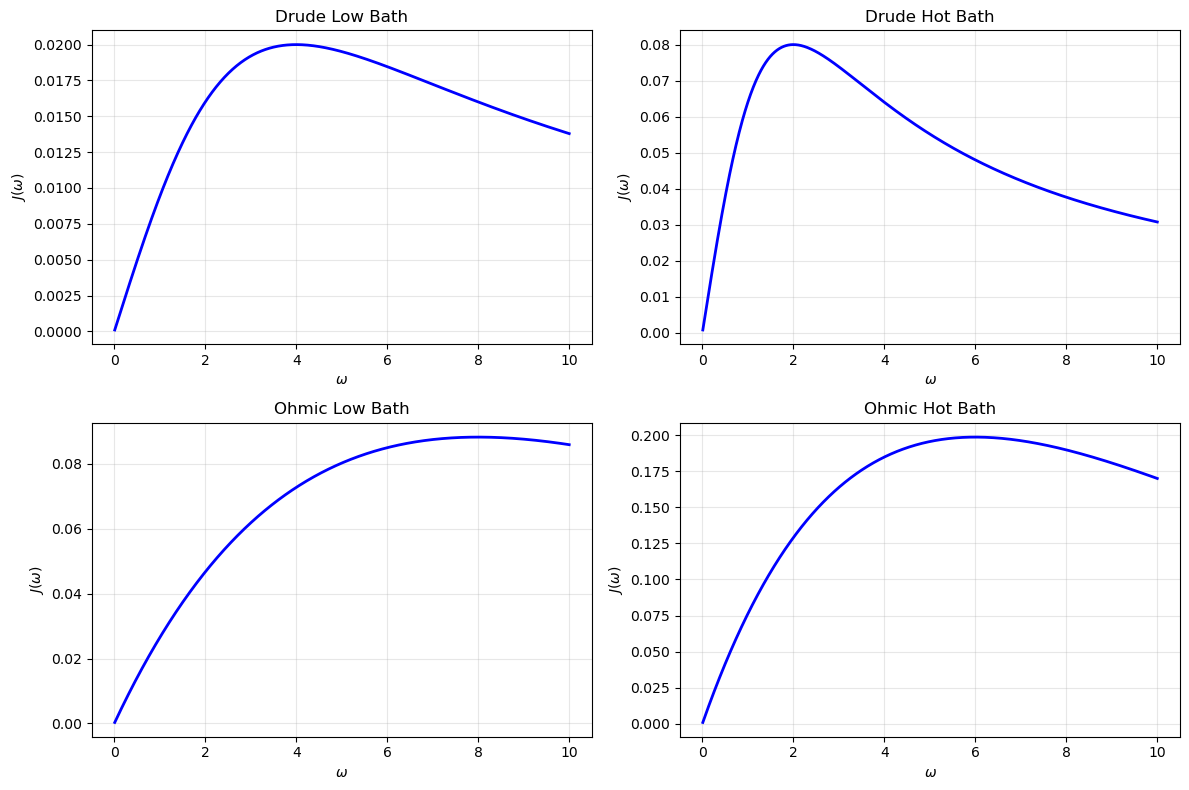

Spectral densities plotted above.


In [2]:
from qutip import DrudeLorentzEnvironment, OhmicEnvironment
from pathlib import Path

# Define bath parameters for our examples
bath_params = {
    'drude_low': {'T': 0.05, 'lam': 0.02, 'gamma': 4.0, 'Nk': 4},
    'drude_hot': {'T': 0.5, 'lam': 0.08, 'gamma': 2.0, 'Nk': 4},
    'ohmic_low': {'T': 0.1, 'wc': 8.0, 'alpha': 0.03, 's': 1.0},
    'ohmic_hot': {'T': 0.6, 'wc': 6.0, 'alpha': 0.09, 's': 1.0}
}

# Create bath objects
baths = {
    'drude_low': DrudeLorentzEnvironment(**bath_params['drude_low']),
    'drude_hot': DrudeLorentzEnvironment(**bath_params['drude_hot']),
    'ohmic_low': OhmicEnvironment(**bath_params['ohmic_low']),
    'ohmic_hot': OhmicEnvironment(**bath_params['ohmic_hot'])
}

# Plot spectral densities
omega = np.linspace(0.01, 10, 1000)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for i, (key, bath) in enumerate(baths.items()):
    ax = axes[i]
    J = [bath.spectral_density(w) for w in omega]
    ax.plot(omega, J, 'b-', linewidth=2)
    ax.set_xlabel(r'$\omega$')
    ax.set_ylabel(r'$J(\omega)$')
    ax.set_title(f'{key.replace("_", " ").title()} Bath')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Spectral densities plotted above.")

## Bloch-Redfield Simulation Setup

Now we'll set up the Bloch-Redfield master equation simulation. The BRME describes the evolution of the system's density matrix under the influence of a weak coupling to the bath.

The key equation is:
$$\dot{\rho} = -i[H, \rho] + \sum_k \gamma_k \mathcal{D}[A_k] \rho$$

where the rates $\gamma_k$ and dissipators $\mathcal{D}[A_k]$ are derived from the bath correlation functions.

Let's define a simulation function and start with our first example.

In [3]:
from qutip import brmesolve
from diagnostics import trajectory_min_eigs
from plotting import populations_from_states

def simulate_driven_tls(bath, tmax=25.0, n_steps=600, w0=1.0, omega_drive=1.0):
    """
    Simulate a driven two-level system with Bloch-Redfield dynamics.

    Parameters:
    - bath: The bath environment object
    - tmax: Maximum simulation time
    - n_steps: Number of time steps
    - w0: TLS frequency
    - omega_drive: Driving amplitude

    Returns:
    - Dictionary with simulation results
    """
    tlist = np.linspace(0.0, tmax, n_steps)

    # Hamiltonian
    H = 0.5 * w0 * sigmaz() + 0.5 * omega_drive * sigmax()

    # Initial state: excited state |1⟩
    psi0 = basis(2, 1)

    # Solve Bloch-Redfield master equation
    # a_ops specifies the system operators coupled to baths
    result = brmesolve(
        H=H,
        psi0=psi0,
        tlist=tlist,
        a_ops=[[sigmax(), bath]],  # σ_x coupled to bath
        e_ops=[],  # No expectation values computed here
        sec_cutoff=-1  # No secular approximation
    )

    # Extract populations
    pops = populations_from_states(result.states)

    # Check positivity (minimal eigenvalues)
    min_eigs = trajectory_min_eigs(result.states)

    return {
        "tlist": tlist,
        "pops": pops,
        "min_eigs": min_eigs,
        "states": result.states,
        "bath": bath
    }

## Example 1: Drude-Lorentz Bath - Low Temperature, Weak Coupling

Let's start with a cold Drude-Lorentz bath with weak coupling. This should show nearly coherent Rabi oscillations, similar to the undamped case.

Parameters:
- Temperature T = 0.05 (cold bath)
- Reorganization energy λ = 0.02 (weak coupling)
- Cutoff frequency γ = 4.0

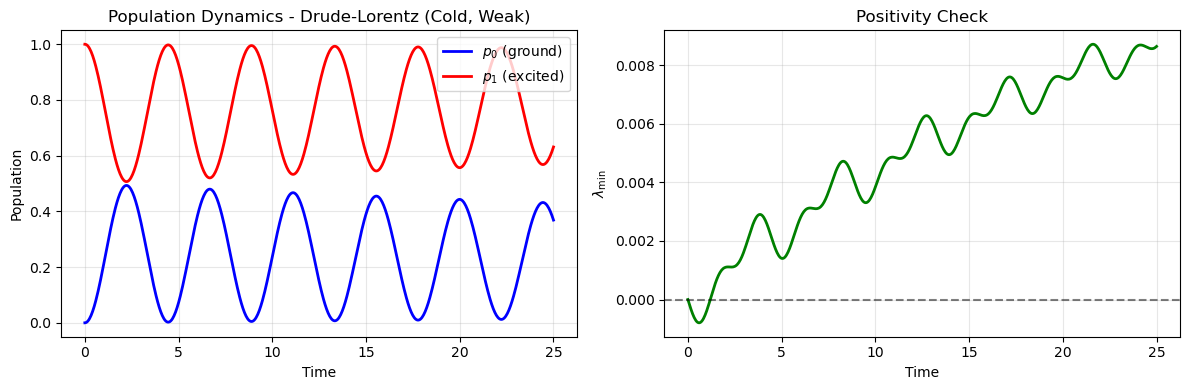

Minimal eigenvalue: -7.95e-04
This shows nearly coherent oscillations with minimal damping.


In [4]:
# Run simulation for Example 1
result1 = simulate_driven_tls(baths['drude_low'])

# Plot populations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Population dynamics
ax1.plot(result1['tlist'], result1['pops'][0], 'b-', label=r'$p_0$ (ground)', linewidth=2)
ax1.plot(result1['tlist'], result1['pops'][1], 'r-', label=r'$p_1$ (excited)', linewidth=2)
ax1.set_xlabel('Time')
ax1.set_ylabel('Population')
ax1.set_title('Population Dynamics - Drude-Lorentz (Cold, Weak)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Minimal eigenvalues (positivity check)
ax2.plot(result1['tlist'], result1['min_eigs'], 'g-', linewidth=2)
ax2.axhline(0, color='k', linestyle='--', alpha=0.5)
ax2.set_xlabel('Time')
ax2.set_ylabel(r'$\lambda_{\min}$')
ax2.set_title('Positivity Check')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Minimal eigenvalue: {result1['min_eigs'].min():.2e}")
print("This shows nearly coherent oscillations with minimal damping.")

## Example 2: Drude-Lorentz Bath - High Temperature, Strong Coupling

Now let's increase both the temperature and coupling strength. This should show significant damping of the Rabi oscillations.

Parameters:
- Temperature T = 0.5 (hot bath)
- Reorganization energy λ = 0.08 (strong coupling)
- Cutoff frequency γ = 2.0

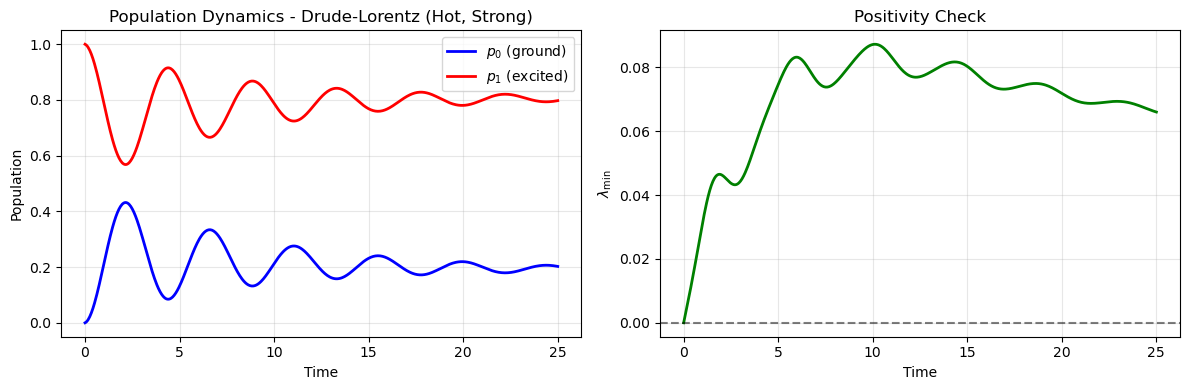

Minimal eigenvalue: 0.00e+00
Strong damping leads to rapid relaxation to thermal equilibrium.


In [5]:
# Run simulation for Example 2
result2 = simulate_driven_tls(baths['drude_hot'])

# Plot populations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Population dynamics
ax1.plot(result2['tlist'], result2['pops'][0], 'b-', label=r'$p_0$ (ground)', linewidth=2)
ax1.plot(result2['tlist'], result2['pops'][1], 'r-', label=r'$p_1$ (excited)', linewidth=2)
ax1.set_xlabel('Time')
ax1.set_ylabel('Population')
ax1.set_title('Population Dynamics - Drude-Lorentz (Hot, Strong)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Minimal eigenvalues
ax2.plot(result2['tlist'], result2['min_eigs'], 'g-', linewidth=2)
ax2.axhline(0, color='k', linestyle='--', alpha=0.5)
ax2.set_xlabel('Time')
ax2.set_ylabel(r'$\lambda_{\min}$')
ax2.set_title('Positivity Check')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Minimal eigenvalue: {result2['min_eigs'].min():.2e}")
print("Strong damping leads to rapid relaxation to thermal equilibrium.")

## Example 3: Ohmic Bath - Low Temperature, Moderate Coupling

Now let's try an Ohmic bath, which has a different spectral density shape. Ohmic baths are common in condensed matter physics.

Parameters:
- Temperature T = 0.1
- Dissipation strength α = 0.03
- Cutoff frequency ω_c = 8.0
- Exponent s = 1.0 (Ohmic)

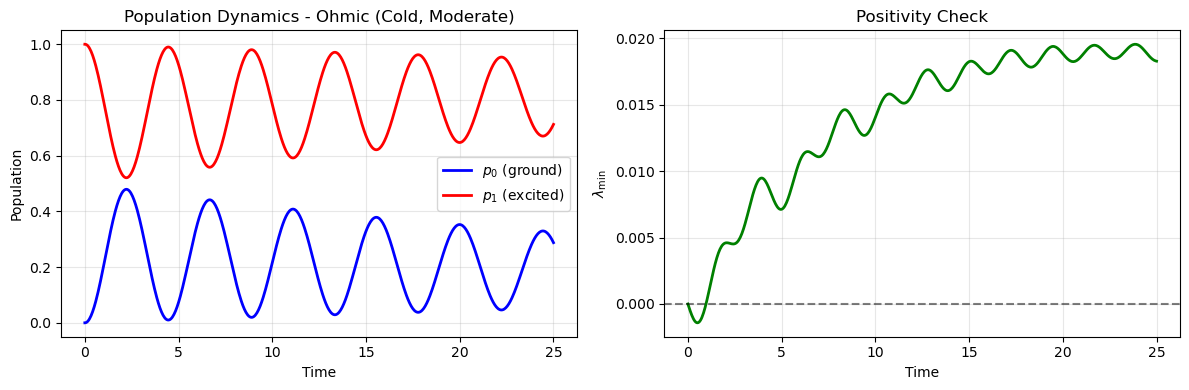

Minimal eigenvalue: -1.41e-03
Ohmic bath shows different damping characteristics compared to Drude-Lorentz.


In [6]:
# Run simulation for Example 3
result3 = simulate_driven_tls(baths['ohmic_low'])

# Plot populations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Population dynamics
ax1.plot(result3['tlist'], result3['pops'][0], 'b-', label=r'$p_0$ (ground)', linewidth=2)
ax1.plot(result3['tlist'], result3['pops'][1], 'r-', label=r'$p_1$ (excited)', linewidth=2)
ax1.set_xlabel('Time')
ax1.set_ylabel('Population')
ax1.set_title('Population Dynamics - Ohmic (Cold, Moderate)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Minimal eigenvalues
ax2.plot(result3['tlist'], result3['min_eigs'], 'g-', linewidth=2)
ax2.axhline(0, color='k', linestyle='--', alpha=0.5)
ax2.set_xlabel('Time')
ax2.set_ylabel(r'$\lambda_{\min}$')
ax2.set_title('Positivity Check')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Minimal eigenvalue: {result3['min_eigs'].min():.2e}")
print("Ohmic bath shows different damping characteristics compared to Drude-Lorentz.")

## Example 4: Ohmic Bath - High Temperature, Strong Coupling

Finally, let's see what happens with a hot, strongly coupled Ohmic bath.

Parameters:
- Temperature T = 0.6
- Dissipation strength α = 0.09
- Cutoff frequency ω_c = 6.0
- Exponent s = 1.0

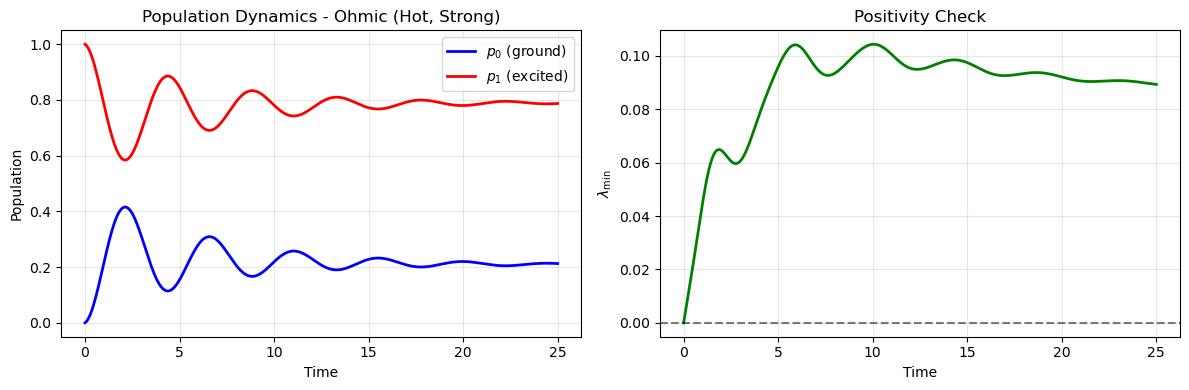

Minimal eigenvalue: 0.00e+00
Strong Ohmic damping leads to very fast relaxation.


In [7]:
# Run simulation for Example 4
result4 = simulate_driven_tls(baths['ohmic_hot'])

# Plot populations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Population dynamics
ax1.plot(result4['tlist'], result4['pops'][0], 'b-', label=r'$p_0$ (ground)', linewidth=2)
ax1.plot(result4['tlist'], result4['pops'][1], 'r-', label=r'$p_1$ (excited)', linewidth=2)
ax1.set_xlabel('Time')
ax1.set_ylabel('Population')
ax1.set_title('Population Dynamics - Ohmic (Hot, Strong)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Minimal eigenvalues
ax2.plot(result4['tlist'], result4['min_eigs'], 'g-', linewidth=2)
ax2.axhline(0, color='k', linestyle='--', alpha=0.5)
ax2.set_xlabel('Time')
ax2.set_ylabel(r'$\lambda_{\min}$')
ax2.set_title('Positivity Check')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Minimal eigenvalue: {result4['min_eigs'].min():.2e}")
print("Strong Ohmic damping leads to very fast relaxation.")

## Comparison of All Scenarios

Now let's compare all four scenarios side by side to see how different bath parameters affect the dynamics.

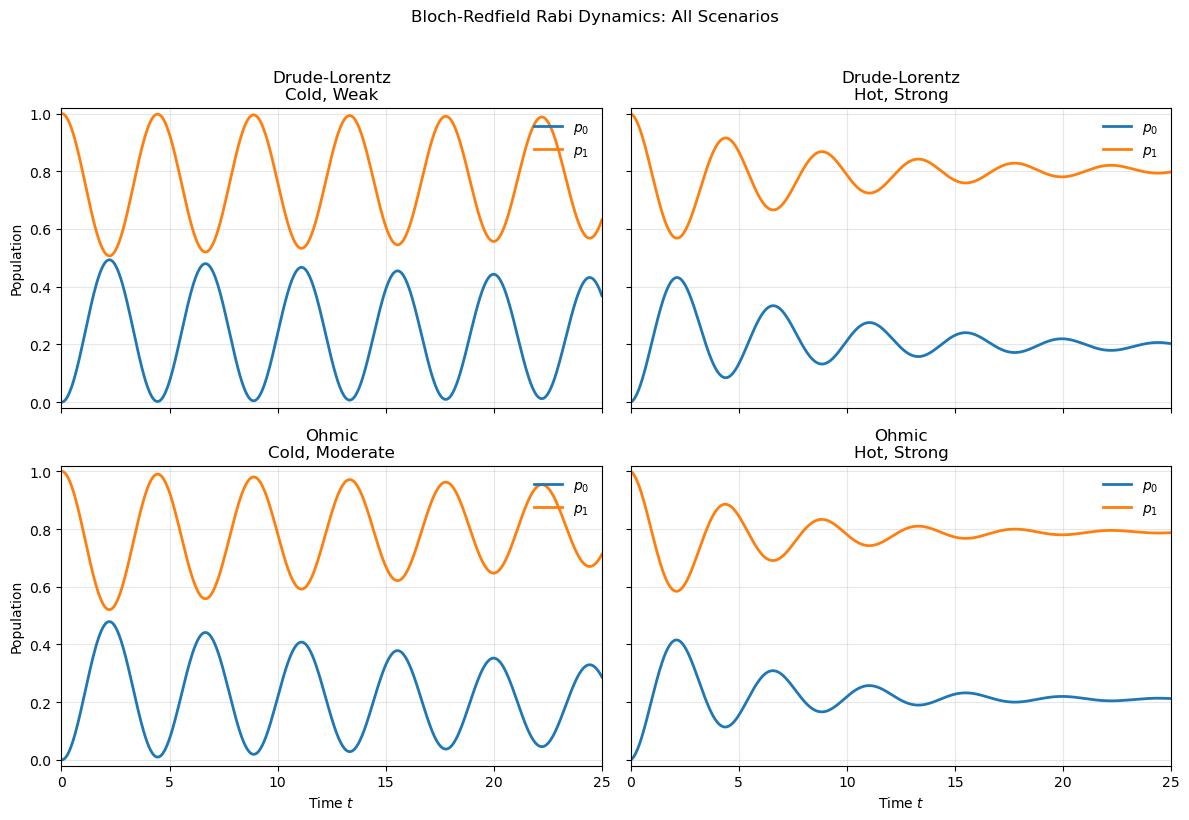

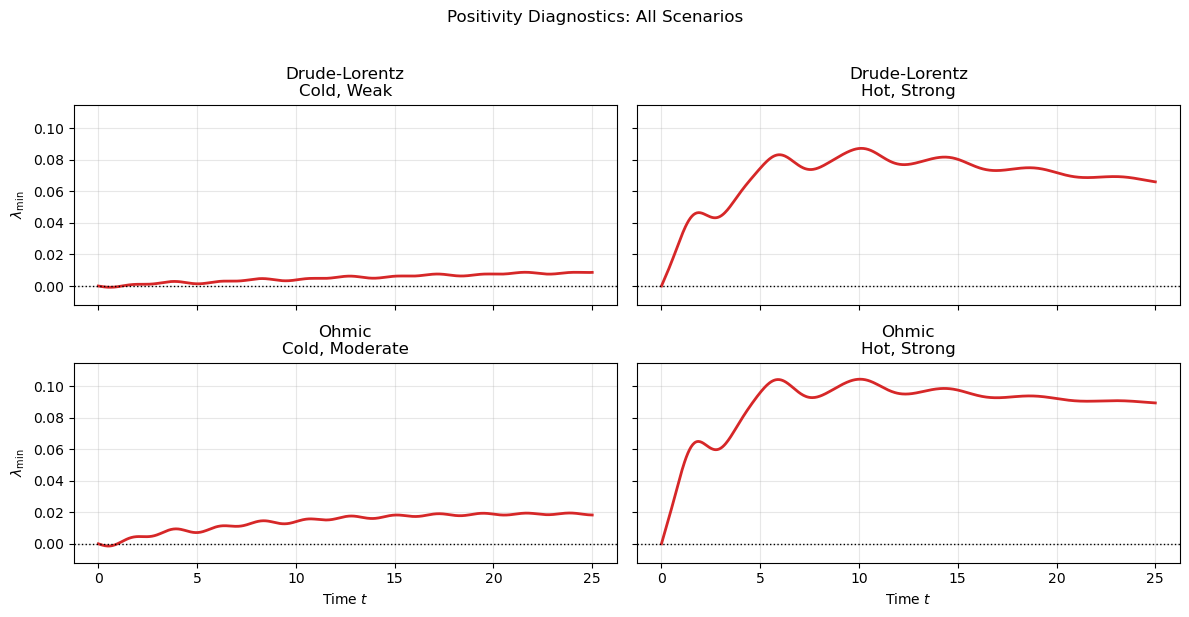

In [8]:
# Collect all results
results = [result1, result2, result3, result4]
titles = [
    'Drude-Lorentz\nCold, Weak',
    'Drude-Lorentz\nHot, Strong',
    'Ohmic\nCold, Moderate',
    'Ohmic\nHot, Strong'
]

# Plot populations comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.ravel()

for ax, res, title in zip(axes, results, titles):
    ax.plot(res['tlist'], res['pops'][0], label=r"$p_0$", color="C0", linewidth=2)
    ax.plot(res['tlist'], res['pops'][1], label=r"$p_1$", color="C1", linewidth=2)
    ax.set_title(title)
    ax.set_xlim(res['tlist'][0], res['tlist'][-1])
    ax.set_ylim(-0.02, 1.02)
    ax.legend(frameon=False, loc="upper right")
    ax.grid(True, alpha=0.3)

for ax in axes[2:]:
    ax.set_xlabel(r"Time $t$")
for ax in axes[::2]:
    ax.set_ylabel("Population")

fig.suptitle("Bloch-Redfield Rabi Dynamics: All Scenarios", y=1.02)
plt.tight_layout()
plt.show()

# Plot minimal eigenvalues comparison
min_all = min(res["min_eigs"].min() for res in results)
max_all = max(res["min_eigs"].max() for res in results)
pad = max(1e-5, 0.1 * (max_all - min_all) if max_all > min_all else 1e-5)
y_limits = (min_all - pad, max_all + pad)

fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey=True)
axes = axes.ravel()

for ax, res, title in zip(axes, results, titles):
    ax.plot(res['tlist'], res['min_eigs'], color="C3", linewidth=2)
    ax.axhline(0.0, color="k", lw=1, ls=":")
    ax.set_title(title)
    ax.set_ylim(*y_limits)
    ax.grid(True, alpha=0.3)

for ax in axes[2:]:
    ax.set_xlabel(r"Time $t$")
for ax in axes[::2]:
    ax.set_ylabel(r"$\lambda_{\min}$")

fig.suptitle("Positivity Diagnostics: All Scenarios", y=1.02)
plt.tight_layout()
plt.show()

## Summary and Key Insights

Let's summarize the key findings from our simulations:

1. **Temperature Effects**: Higher temperatures generally lead to faster relaxation and stronger damping.

2. **Coupling Strength**: Stronger coupling (higher λ or α) accelerates the decay of Rabi oscillations.

3. **Bath Type**: Drude-Lorentz and Ohmic baths produce different damping characteristics due to their spectral densities.

4. **Positivity**: The Bloch-Redfield master equation can sometimes predict non-physical negative probabilities (λ_min < 0), indicating breakdown of the weak coupling approximation.

Here's a quantitative summary:

In [9]:
import pandas as pd

# Create summary table
summary_data = []
for i, (res, title) in enumerate(zip(results, titles)):
    coupling = [0.02, 0.08, 0.03, 0.09][i]  # From bath params
    temp = [0.05, 0.5, 0.1, 0.6][i]
    min_lambda = res['min_eigs'].min()
    final_pop0 = res['pops'][0][-1]
    final_pop1 = res['pops'][1][-1]

    summary_data.append({
        'Scenario': title.replace('\n', ' '),
        'Temperature': temp,
        'Coupling': coupling,
        'Min λ': f"{min_lambda:.2e}",
        'Final p₀': f"{final_pop0:.3f}",
        'Final p₁': f"{final_pop1:.3f}"
    })

df = pd.DataFrame(summary_data)
print("Summary of all scenarios:")
print(df.to_string(index=False))

print("\nKey observations:")
print("- Lower temperature and coupling preserve oscillations")
print("- Higher temperature/coupling lead to thermal equilibrium")
print("- Some scenarios show negative eigenvalues (positivity violation)")
print("- Different bath types affect relaxation rates differently")

Summary of all scenarios:
                 Scenario  Temperature  Coupling     Min λ Final p₀ Final p₁
 Drude-Lorentz Cold, Weak         0.05      0.02 -7.95e-04    0.369    0.631
Drude-Lorentz Hot, Strong         0.50      0.08  0.00e+00    0.202    0.798
     Ohmic Cold, Moderate         0.10      0.03 -1.41e-03    0.288    0.712
        Ohmic Hot, Strong         0.60      0.09  0.00e+00    0.213    0.787

Key observations:
- Lower temperature and coupling preserve oscillations
- Higher temperature/coupling lead to thermal equilibrium
- Some scenarios show negative eigenvalues (positivity violation)
- Different bath types affect relaxation rates differently
